## GMM pose space model with scalar morph

### Setup

In [2]:
%load_ext autoreload
%autoreload 2 --print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from kpsn.models.morph import scalar
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util

from mph.generative.test.visualize import mixtures

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np
import optax
import jax
from tensorflow_probability.substrates import jax as tfp
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from matplotlib import gridspec

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Sample dataset

In [5]:
T = 100; N = 3; M = 2; L = 5; eps = 0.05
morph_hyperparams = scalar.ScalarMorphHyperparams(N = N, M = M)
pose_hyperparams = gmm.GMMHyperparams(N = N, M = M, L = L, eps = eps)
model = joint_model.JointModel(morph = scalar.ScalarMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

gt_morph, gt_pose, gt_latents, gt_obs = joint_model.sample(
    jr.PRNGKey(0), T,
    model,
    hyperparams,
    dict(log_std = 0.3),
    dict(
        pi_logit_means = jnp.stack([2 * jnp.exp(jnp.linspace(-i_subj / 10, i_subj / 10, L))
                                    for i_subj in range(pose_hyperparams.N)]),
        pi_logit_vars = 0.06 * jnp.ones([N, L]),
        m_norm_center = 2,
        m_norm_spread = 0.4,
        q_var_center = 0.5,
        q_var_spread = 0.1),
)

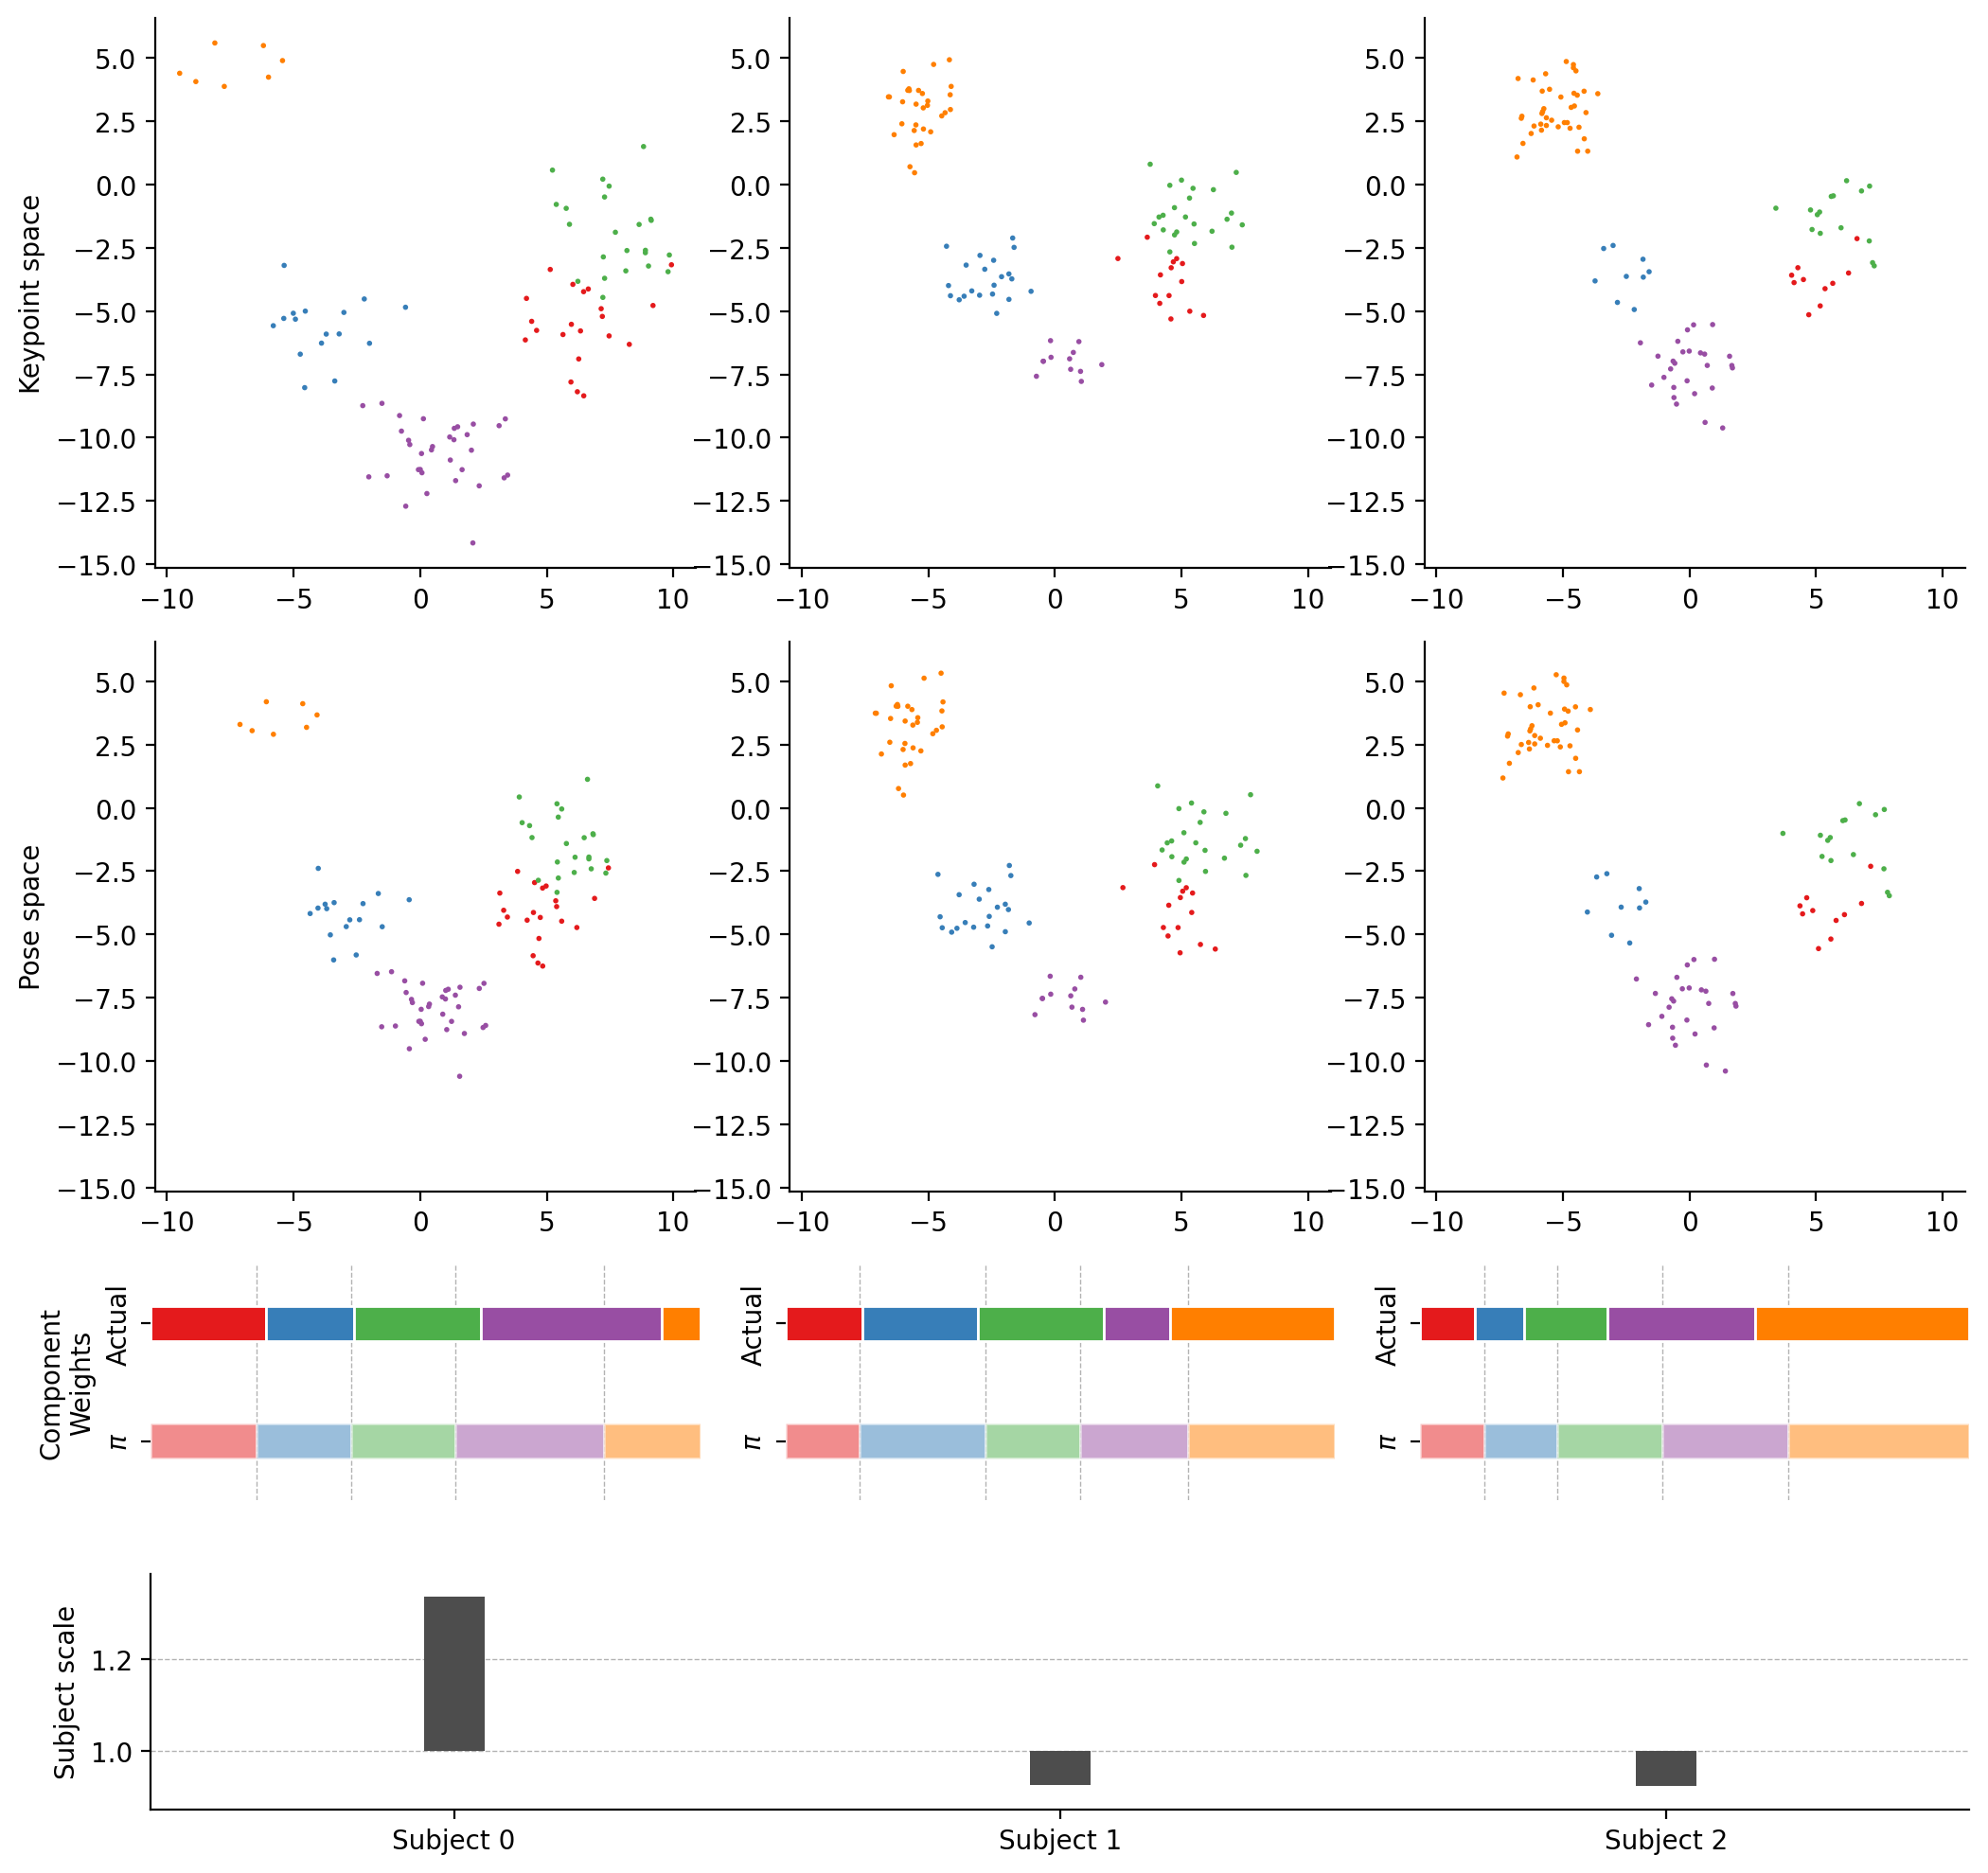

In [6]:
fig = plt.figure(figsize = (3.5 * pose_hyperparams.N, 7 + 1.5 + 1.5))
gs = gridspec.GridSpec(
    4, pose_hyperparams.N ,
    height_ratios = [3.5, 3.5, 1.5, 1.5])
ax = np.array([[
    fig.add_subplot(gs[r, c])
    for c in range(pose_hyperparams.N)]for r in range(3)])

comp_pal = np.array(sns.color_palette('Set1', n_colors = pose_hyperparams.L))

for i_subj in range(N):
    ax[0, i_subj].scatter(
        x = gt_obs.unstack(gt_obs.keypts)[i_subj][:, 0],
        y = gt_obs.unstack(gt_obs.keypts)[i_subj][:, 1],
        c = comp_pal[gt_obs.unstack(gt_latents.components)[i_subj]],
        s = 1,
    )
    sns.despine(ax=ax[0, i_subj])
    ax[0, i_subj].set_aspect(1.)
    if i_subj != 0:
        ax[0, i_subj].sharex(ax[0, 0])
        ax[0, i_subj].sharey(ax[0, 0])

    ax[1, i_subj].scatter(
        x = gt_obs.unstack(gt_latents.poses)[i_subj][:, 0],
        y = gt_obs.unstack(gt_latents.poses)[i_subj][:, 1],
        c = comp_pal[gt_obs.unstack(gt_latents.components)[i_subj]],
        s = 1,)
    sns.despine(ax=ax[1, i_subj])
    ax[1, i_subj].set_aspect(1.)
    ax[1, i_subj].sharex(ax[0, 0])
    ax[1, i_subj].sharey(ax[0, 0])

    empirical_latent_dist = jnp.histogram(
        gt_obs.unstack(gt_latents.components)[i_subj],
        jnp.arange(pose_hyperparams.L+1) - 0.5,
        density = True)[0]
    mixtures.compare_dirichlet_blocks(
        gt_pose.weights()[i_subj],
        [empirical_latent_dist],
        pal = comp_pal,
        ax = ax[2, i_subj],
        orientation = 'horizontal',
        labels = [r"$\pi$", 'Actual'],
        label_kwargs = dict(rotation = 90, verticalalignment = "center"))
    sns.despine(ax = ax[2, i_subj], bottom = True, left = True)

scale_ax = fig.add_subplot(gs[-1, :])
scales = jnp.exp(gt_morph.scale_log)
scale_ax.bar(
    np.arange(pose_hyperparams.N),
    jnp.maximum(scales - 1, 0) - jnp.minimum(scales - 1, 0),
    bottom = jnp.minimum(scales - 1, 0) + 1,
    color = '.3', zorder = 2, width = 0.1
)
scale_ax.set_xlim([-0.5, pose_hyperparams.N - 1 + 0.5])
scale_ax.set_ylim([scales.min() - 0.05, scales.max() + 0.05])
for tick in scale_ax.get_yticks()[1:-1]:
    scale_ax.axhline(tick, ls = '--', lw = 0.5, color = '.7', zorder = 1)

scale_ax.set_xticks(np.arange(pose_hyperparams.N))
scale_ax.set_xticklabels([f"Subject {i_subj}" for i_subj in range(pose_hyperparams.N)])
scale_ax.set_ylabel("Subject scale")
sns.despine(ax = scale_ax)

ax[0, 0].set_ylabel("Keypoint space")
ax[1, 0].set_ylabel("Pose space")
ax[2, 0].set_ylabel("Component\nWeights")
fig.tight_layout()
plt.show()

### Single M-step

In [58]:
loss_hist, fit_params = em.mstep(
    model = model,
    # init_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.0),
    # estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.0),
    init_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    estimated_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    emissions = gt_obs,
    hyperparams = hyperparams,
    optimizer = optax.adam(learning_rate=5e-4),
    n_steps = 2000,
    log_every = -1,
    progress = False
)

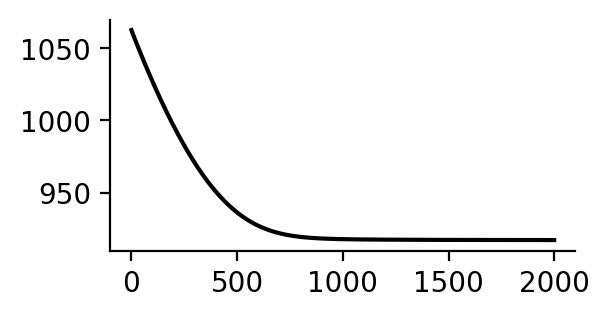

In [59]:
plt.figure(figsize = (3, 1.5))
plt.plot(loss_hist, 'k-')
sns.despine()

### Debugging

In [46]:
from kpsn.util.computations import gaussian_product
from tensorflow_probability.substrates import jax as tfp

In [51]:

T, N = 7, 5
a = np.random.randn(T, 1); b = np.random.randn(N, 1)
A = 0.5 * abs(np.random.randn(T, 1, 1)); B = 0.5 * abs(np.random.randn(N, 1, 1))

K, c, C = gaussian_product(
    a[:, None], A[:, None], b[None, :], B[None, :])

qA, 0.8186483979225159, qB 28.138824462890625, qC 24.983827590942383
Kexp 0.33391061425209045


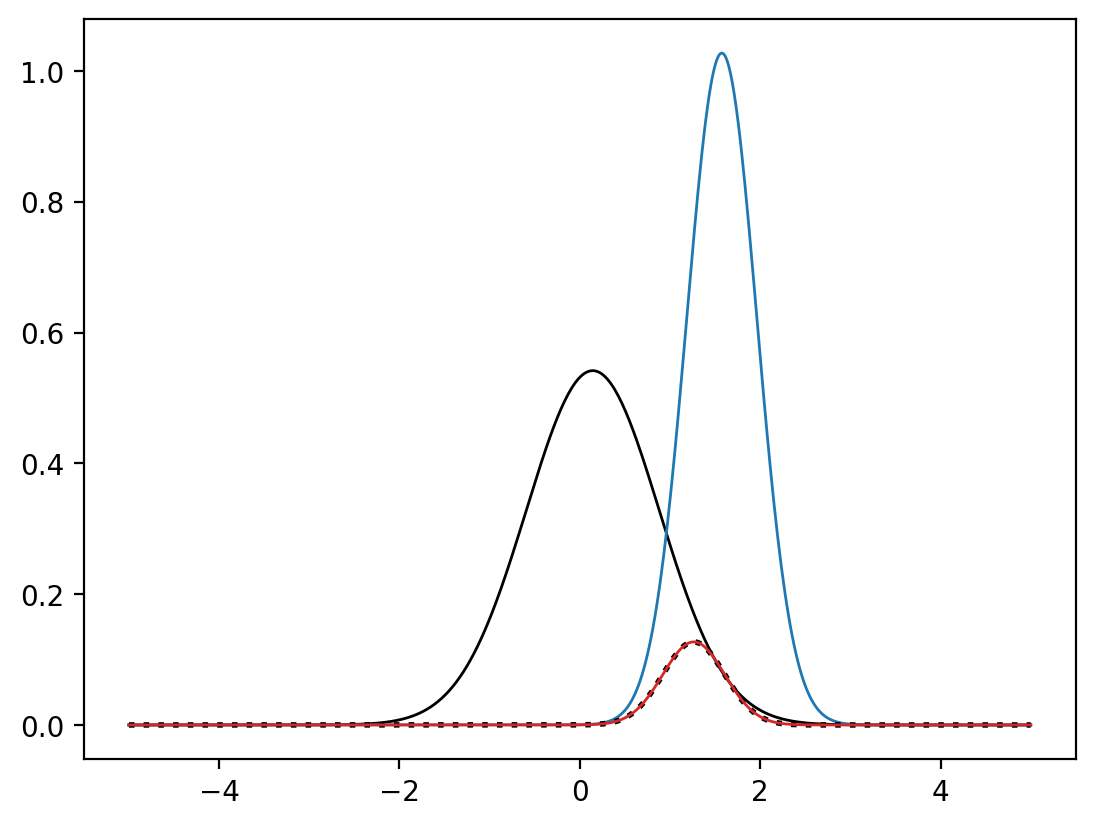

In [54]:
t = 3; z = 2
plot_lim = 5
query_x = np.linspace(-plot_lim, plot_lim, 500)

obs_color = 'k'
est_color = 'C0'
cbn_color = 'C3'

obs_dist = tfp.distributions.Normal(loc = a[t, 0], scale = np.sqrt(A[t, 0, 0])).prob(query_x)
est_dist = tfp.distributions.Normal(loc = b[z, 0], scale = np.sqrt(B[z, 0, 0])).prob(query_x)
cbn_dist = tfp.distributions.Normal(loc = c[t, z, 0], scale = np.sqrt(C[t, z, 0, 0])).prob(query_x)

fig, ax = plt.subplots()
plt.plot(query_x, obs_dist, '-', lw = 1, color = obs_color)
plt.plot(query_x, est_dist, '-', lw = 1, color = est_color)
plt.plot(query_x, obs_dist * est_dist, ':', lw = 2, color = obs_color)
plt.plot(query_x, K[t, z] * cbn_dist, '-', lw = 1, color = cbn_color)

plt.show()

##### Next

`quadform` appears to compute the right thing - next, look at the objects going into `quadform` during `gmm.aux_dist` to see if we do what we think they're doing.
- Refactor out the inverted-linear normal and numerically confirm